# Edge Detection Filter 적용하기

dog-puppy.png 이미지에 edge detection kernel filter를 적용하여 경계선을 검출해보겠습니다.

사용할 kernel:
```
[ 0, -1,  0]
[-1,  4, -1]
[ 0, -1,  0]
```

이는 라플라시안(Laplacian) edge detection filter입니다.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# 맥북 한글 폰트 설정
import platform
from matplotlib import font_manager

def setup_korean_font():
    """맥북에서 사용 가능한 한글 폰트를 찾아서 설정"""
    system = platform.system()
    print(f"🖥️ 운영체제: {system}")
    
    if system == 'Darwin':  # macOS
        # 맥북에서 사용 가능한 한글 폰트 목록 (우선순위 순)
        korean_fonts = [
            'AppleSDGothicNeo-Regular',
            'AppleGothic', 
            'Nanum Gothic',
            'NanumGothic',
            'Malgun Gothic',
            'Arial Unicode MS'
        ]
        
        # 시스템에 설치된 폰트 목록 가져오기
        available_fonts = [f.name for f in font_manager.fontManager.ttflist]
        
        # 사용 가능한 한글 폰트 찾기
        selected_font = None
        for font in korean_fonts:
            if font in available_fonts:
                selected_font = font
                break
        
        if selected_font:
            plt.rcParams['font.family'] = selected_font
            print(f"✅ 한글 폰트 설정 완료: {selected_font}")
        else:
            # 대안: 유니코드 지원 폰트 사용
            plt.rcParams['font.family'] = 'Arial Unicode MS'
            print("⚠️ 기본 한글 폰트를 찾을 수 없어 Arial Unicode MS 사용")
            
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        print(f"✅ 한글 폰트 설정: Malgun Gothic")
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 마이너스 기호 깨짐 방지 설정 완료")

# 한글 폰트 설정 실행
setup_korean_font()


2025-09-24 19:22:02.405624: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aaron/Github/Kmong/Aaron/hg-mldl2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


🖥️ 운영체제: Darwin
✅ 한글 폰트 설정 완료: AppleGothic
✅ 마이너스 기호 깨짐 방지 설정 완료


In [1]:
# 필요한 라이브러리 import
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy.ndimage import convolve

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'


이미지 크기: (424, 425, 4)
이미지 데이터 타입: uint8


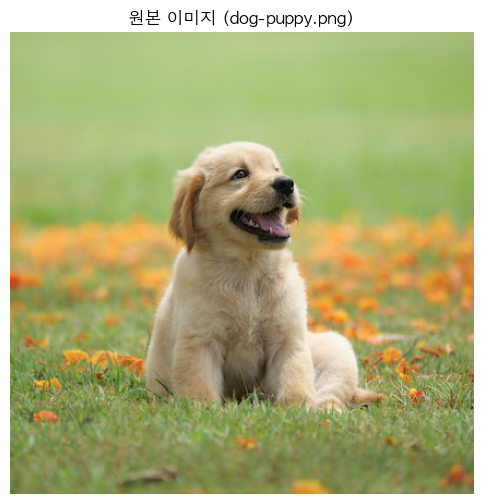

In [4]:
# 이미지 읽어오기
image_path = 'dog-puppy.png'
img = Image.open(image_path)

# 이미지를 numpy array로 변환
img_array = np.array(img)

print(f"이미지 크기: {img_array.shape}")
print(f"이미지 데이터 타입: {img_array.dtype}")

# 원본 이미지 표시
plt.figure(figsize=(8, 6))
plt.imshow(img_array)
plt.title('원본 이미지 (dog-puppy.png)')
plt.axis('off')
plt.show()


컬러 이미지를 그레이스케일로 변환했습니다.
그레이스케일 이미지 크기: (424, 425)


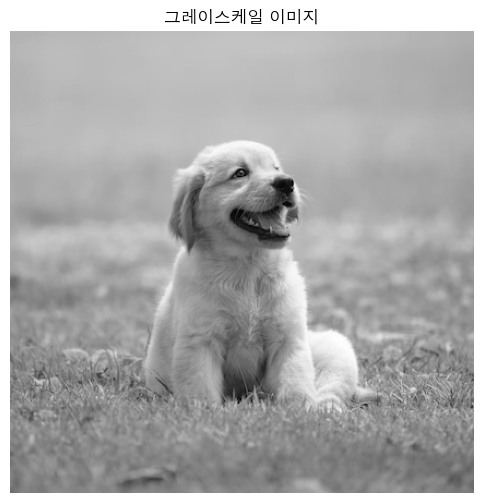

In [5]:
# 이미지가 컬러인 경우 그레이스케일로 변환
if len(img_array.shape) == 3:
    # RGB 이미지인 경우 그레이스케일로 변환
    gray_img = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    print("컬러 이미지를 그레이스케일로 변환했습니다.")
else:
    gray_img = img_array
    print("이미지가 이미 그레이스케일입니다.")

print(f"그레이스케일 이미지 크기: {gray_img.shape}")

# 그레이스케일 이미지 표시
plt.figure(figsize=(8, 6))
plt.imshow(gray_img, cmap='gray')
plt.title('그레이스케일 이미지')
plt.axis('off')
plt.show()


In [11]:
# Edge Detection Kernel 정의
# 라플라시안 edge detection kernel
edge_kernel = np.array([
    [ 0, -1,  0],
    [-1,  4, -1],
    [ 0, -1,  0]
])

print("Edge Detection Kernel:")
print(edge_kernel)
print(f"Kernel 크기: {edge_kernel.shape}")


Edge Detection Kernel:
[[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]
Kernel 크기: (3, 3)


In [12]:
# Edge Detection Filter 적용
# scipy.ndimage.convolve를 사용하여 convolution 연산 수행
filtered_img = convolve(gray_img.astype(np.float32), edge_kernel, mode='constant', cval=0)

print(f"필터 적용 후 이미지 크기: {filtered_img.shape}")
print(f"필터 적용 후 이미지 데이터 범위: {filtered_img.min():.2f} ~ {filtered_img.max():.2f}")

# 결과를 0-255 범위로 정규화
filtered_img_normalized = np.clip(filtered_img, 0, 255).astype(np.uint8)
print(f"정규화 후 이미지 데이터 범위: {filtered_img_normalized.min()} ~ {filtered_img_normalized.max()}")


필터 적용 후 이미지 크기: (424, 425)
필터 적용 후 이미지 데이터 범위: -385.00 ~ 348.00
정규화 후 이미지 데이터 범위: 0 ~ 255


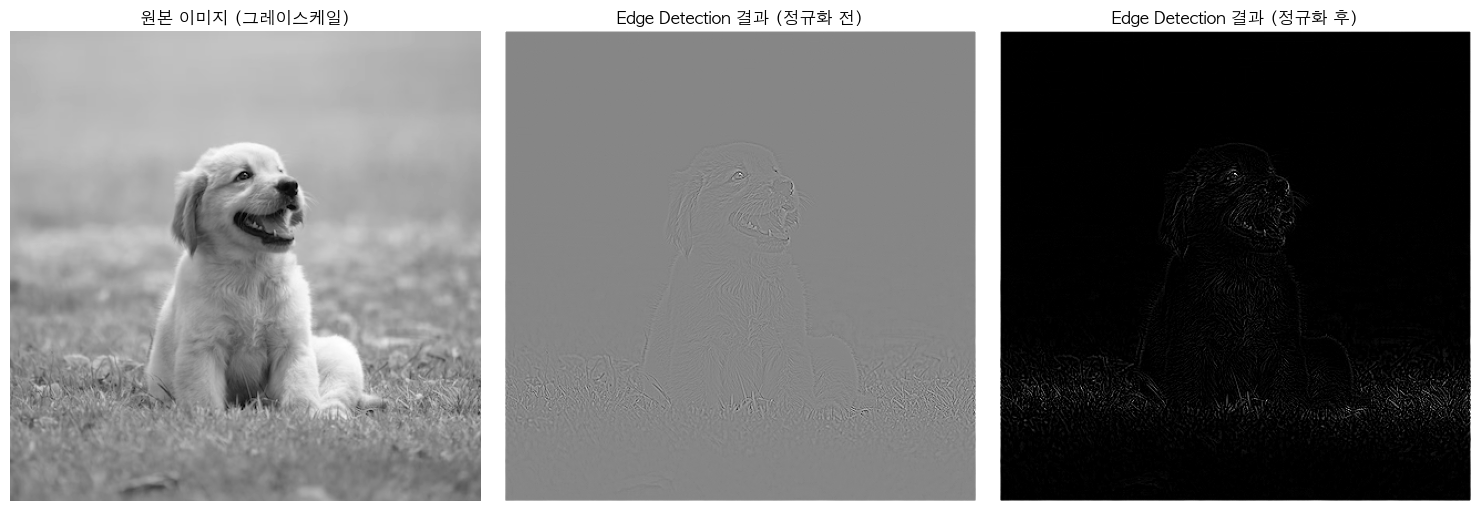

In [8]:
# 결과 시각화 - 원본과 필터 적용 결과 비교
plt.figure(figsize=(15, 5))

# 원본 이미지 (그레이스케일)
plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('원본 이미지 (그레이스케일)')
plt.axis('off')

# Edge detection 결과 (정규화 전)
plt.subplot(1, 3, 2)
plt.imshow(filtered_img, cmap='gray')
plt.title('Edge Detection 결과 (정규화 전)')
plt.axis('off')

# Edge detection 결과 (정규화 후)
plt.subplot(1, 3, 3)
plt.imshow(filtered_img_normalized, cmap='gray')
plt.title('Edge Detection 결과 (정규화 후)')
plt.axis('off')

plt.tight_layout()
plt.show()


## Gaussian Blur Filter 적용

이번에는 Gaussian blur kernel을 적용해보겠습니다.

사용할 Gaussian blur kernel:
```
1/16 * [1  2  1]
       [2  4  2]  
       [1  2  1]
```

이 kernel은 이미지를 부드럽게 만들어 노이즈를 줄이는 효과가 있습니다.


In [14]:
# Gaussian Blur Kernel 정의
gaussian_kernel = (1/16) * np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
])

print("Gaussian Blur Kernel:")
print(gaussian_kernel)
print(f"Kernel 크기: {gaussian_kernel.shape}")
print(f"Kernel 합계: {gaussian_kernel.sum():.4f} (정규화된 kernel의 합은 1이어야 함)")


Gaussian Blur Kernel:
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]
Kernel 크기: (3, 3)
Kernel 합계: 1.0000 (정규화된 kernel의 합은 1이어야 함)


In [15]:
# Gaussian Blur Filter 적용
blurred_img = convolve(gray_img.astype(np.float32), gaussian_kernel, mode='constant', cval=0)

print(f"Gaussian blur 적용 후 이미지 크기: {blurred_img.shape}")
print(f"Gaussian blur 적용 후 이미지 데이터 범위: {blurred_img.min():.2f} ~ {blurred_img.max():.2f}")

# 결과를 0-255 범위로 정규화
blurred_img_normalized = np.clip(blurred_img, 0, 255).astype(np.uint8)
print(f"정규화 후 이미지 데이터 범위: {blurred_img_normalized.min()} ~ {blurred_img_normalized.max()}")


Gaussian blur 적용 후 이미지 크기: (424, 425)
Gaussian blur 적용 후 이미지 데이터 범위: 7.19 ~ 248.44
정규화 후 이미지 데이터 범위: 7 ~ 248


/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1287074240.py:105: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1287074240.py:105: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1287074240.py:105: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1287074240.py:105: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1287074240.py:105: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1

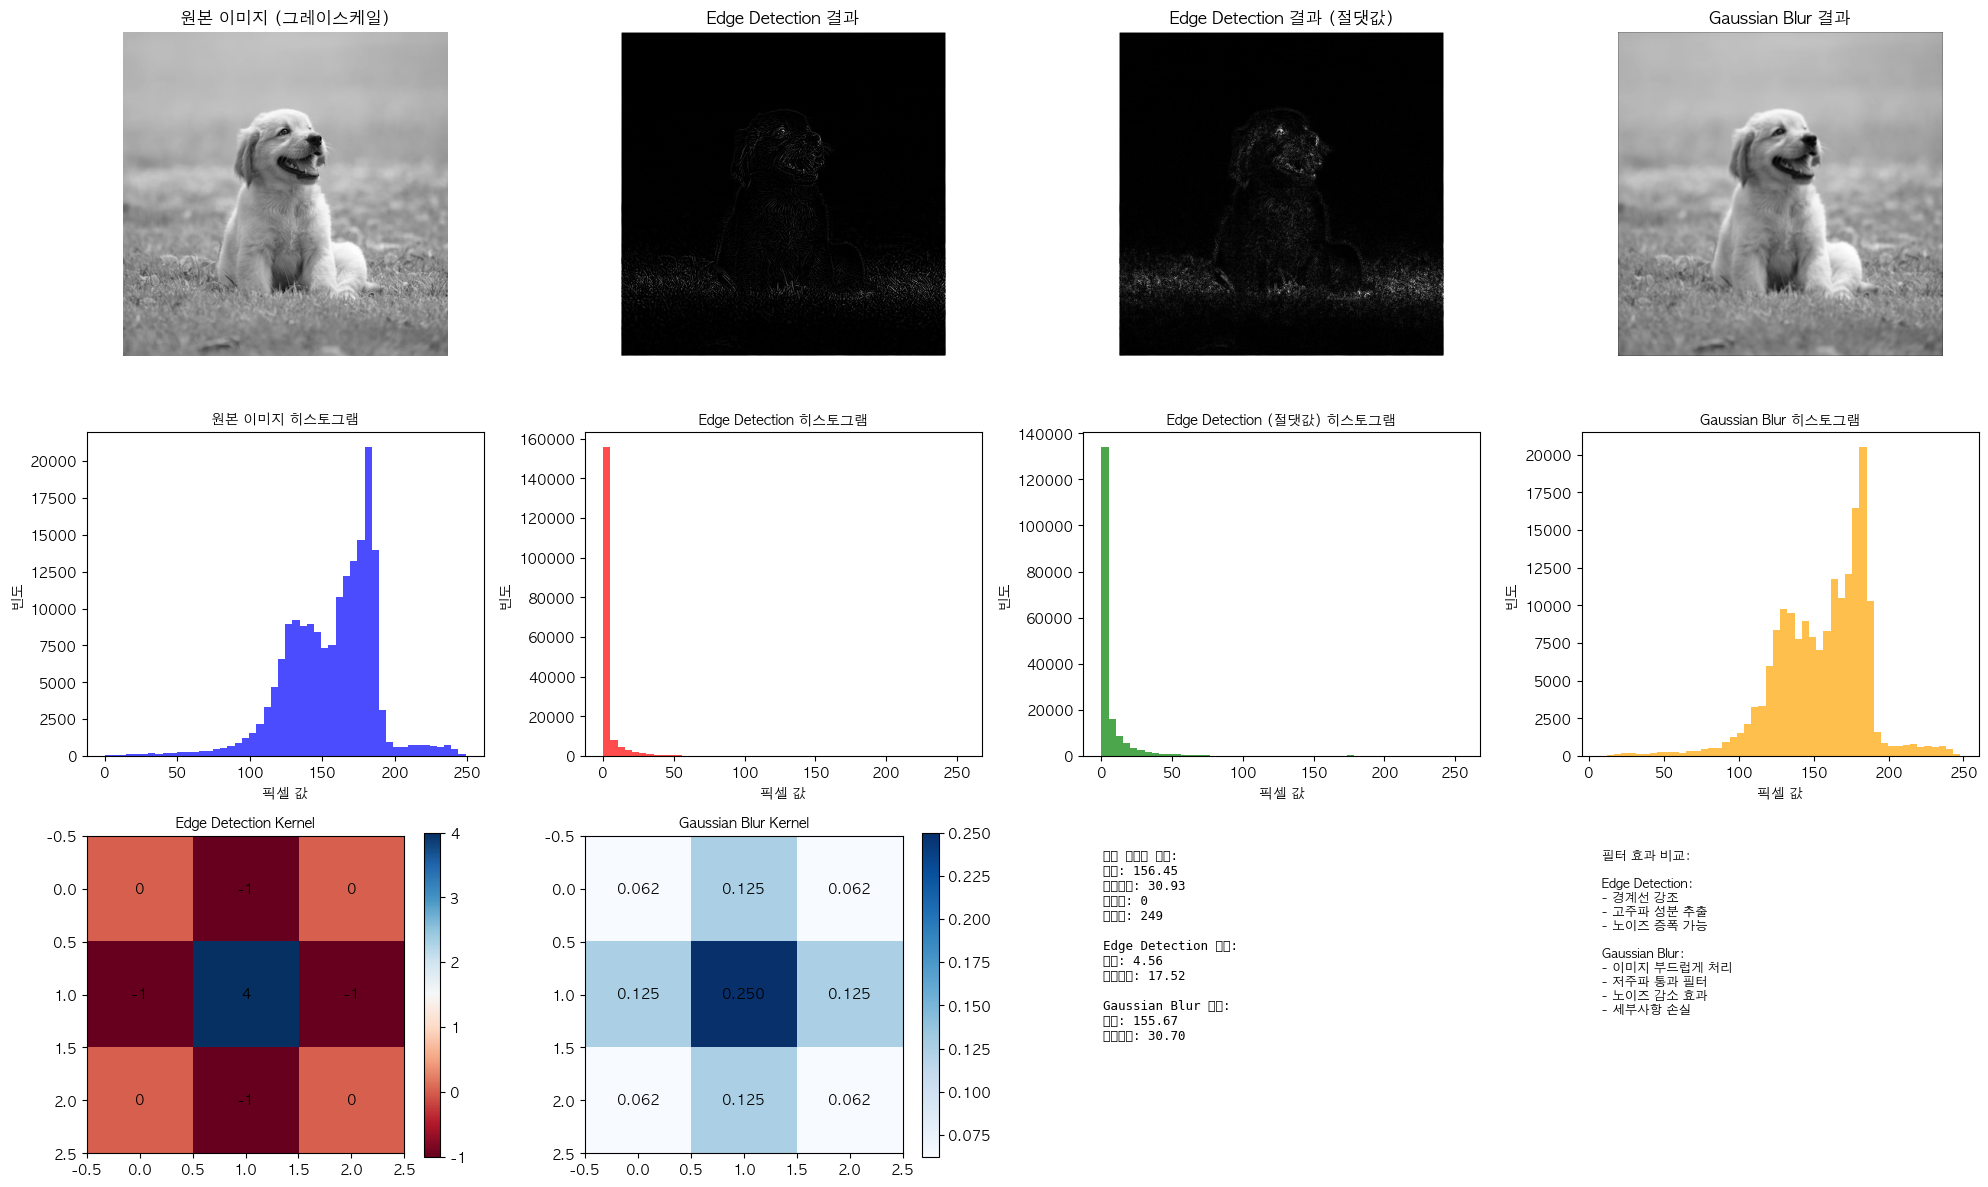

In [16]:
# 모든 결과 비교 - 원본, Edge Detection, Gaussian Blur
plt.figure(figsize=(20, 12))

# 첫 번째 행: 이미지 결과들
plt.subplot(3, 4, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('원본 이미지 (그레이스케일)', fontsize=12)
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(filtered_img_normalized, cmap='gray')
plt.title('Edge Detection 결과', fontsize=12)
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(filtered_img_abs_normalized, cmap='gray')
plt.title('Edge Detection 결과 (절댓값)', fontsize=12)
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(blurred_img_normalized, cmap='gray')
plt.title('Gaussian Blur 결과', fontsize=12)
plt.axis('off')

# 두 번째 행: 히스토그램
plt.subplot(3, 4, 5)
plt.hist(gray_img.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('원본 이미지 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(3, 4, 6)
plt.hist(filtered_img_normalized.flatten(), bins=50, alpha=0.7, color='red')
plt.title('Edge Detection 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(3, 4, 7)
plt.hist(filtered_img_abs_normalized.flatten(), bins=50, alpha=0.7, color='green')
plt.title('Edge Detection (절댓값) 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(3, 4, 8)
plt.hist(blurred_img_normalized.flatten(), bins=50, alpha=0.7, color='orange')
plt.title('Gaussian Blur 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

# 세 번째 행: Kernel 시각화
plt.subplot(3, 4, 9)
plt.imshow(edge_kernel, cmap='RdBu', interpolation='nearest')
plt.title('Edge Detection Kernel', fontsize=10)
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{edge_kernel[i,j]}', ha='center', va='center', fontweight='bold')

plt.subplot(3, 4, 10)
plt.imshow(gaussian_kernel, cmap='Blues', interpolation='nearest')
plt.title('Gaussian Blur Kernel', fontsize=10)
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{gaussian_kernel[i,j]:.3f}', ha='center', va='center', fontweight='bold')

# 세 번째 행: 통계 정보
plt.subplot(3, 4, 11)
stats_text = f"""원본 이미지 통계:
평균: {gray_img.mean():.2f}
표준편차: {gray_img.std():.2f}
최솟값: {gray_img.min()}
최댓값: {gray_img.max()}

Edge Detection 통계:
평균: {filtered_img_normalized.mean():.2f}
표준편차: {filtered_img_normalized.std():.2f}

Gaussian Blur 통계:
평균: {blurred_img_normalized.mean():.2f}
표준편차: {blurred_img_normalized.std():.2f}"""

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=9, family='monospace')
plt.axis('off')

plt.subplot(3, 4, 12)
comparison_text = """필터 효과 비교:

Edge Detection:
- 경계선 강조
- 고주파 성분 추출
- 노이즈 증폭 가능

Gaussian Blur:
- 이미지 부드럽게 처리
- 저주파 통과 필터
- 노이즈 감소 효과
- 세부사항 손실"""

plt.text(0.05, 0.95, comparison_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=9)
plt.axis('off')

plt.tight_layout()
plt.show()


## 결과 분석 및 요약

### 사용된 Kernel들:

1. **Edge Detection Kernel (라플라시안)**:
   ```
   [ 0, -1,  0]
   [-1,  4, -1]
   [ 0, -1,  0]
   ```
   - 중심 픽셀 주변의 변화량을 계산하여 경계선을 검출
   - 고주파 성분을 강조하는 high-pass filter

2. **Gaussian Blur Kernel**:
   ```
   1/16 * [1  2  1]
          [2  4  2]  
          [1  2  1]
   ```
   - 주변 픽셀들의 가중평균을 계산하여 이미지를 부드럽게 처리
   - 저주파 성분만 통과시키는 low-pass filter

### 필터 효과:
- **Edge Detection**: 강아지의 윤곽선과 털의 경계가 뚜렷하게 강조됨
- **Gaussian Blur**: 이미지가 부드러워지고 세부적인 노이즈가 감소됨


## Sharpen Filter 적용

이번에는 Sharpen kernel을 적용해보겠습니다.

사용할 Sharpen kernel:
```
[ 0, -1,  0]
[-1,  5, -1]
[ 0, -1,  0]
```

이 kernel은 이미지의 선명도를 높이는 효과가 있습니다. Edge detection과 비슷하지만 중심값이 더 커서 원본 이미지의 정보를 유지하면서 경계선을 강조합니다.


In [18]:
# Sharpen Kernel 정의
sharpen_kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

print("Sharpen Kernel:")
print(sharpen_kernel)
print(f"Kernel 크기: {sharpen_kernel.shape}")
print(f"Kernel 합계: {sharpen_kernel.sum()} (sharpen kernel의 합은 1이어야 함)")


Sharpen Kernel:
[[ 0 -1  0]
 [-1  5 -1]
 [ 0 -1  0]]
Kernel 크기: (3, 3)
Kernel 합계: 1 (sharpen kernel의 합은 1이어야 함)


In [20]:
# Sharpen Filter 적용
sharpened_img = convolve(gray_img.astype(np.float32), sharpen_kernel, mode='constant', cval=0)

print(f"Sharpen 적용 후 이미지 크기: {sharpened_img.shape}")
print(f"Sharpen 적용 후 이미지 데이터 범위: {sharpened_img.min():.2f} ~ {sharpened_img.max():.2f}")

# 결과를 0-255 범위로 정규화
sharpened_img_normalized = np.clip(sharpened_img, 0, 255).astype(np.uint8)
print(f"정규화 후 이미지 데이터 범위: {sharpened_img_normalized.min()} ~ {sharpened_img_normalized.max()}")


Sharpen 적용 후 이미지 크기: (424, 425)
Sharpen 적용 후 이미지 데이터 범위: -356.00 ~ 522.00
정규화 후 이미지 데이터 범위: 0 ~ 255


/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1236752080.py:154: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1236752080.py:154: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1236752080.py:154: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1236752080.py:154: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/1236752080.py:154: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1

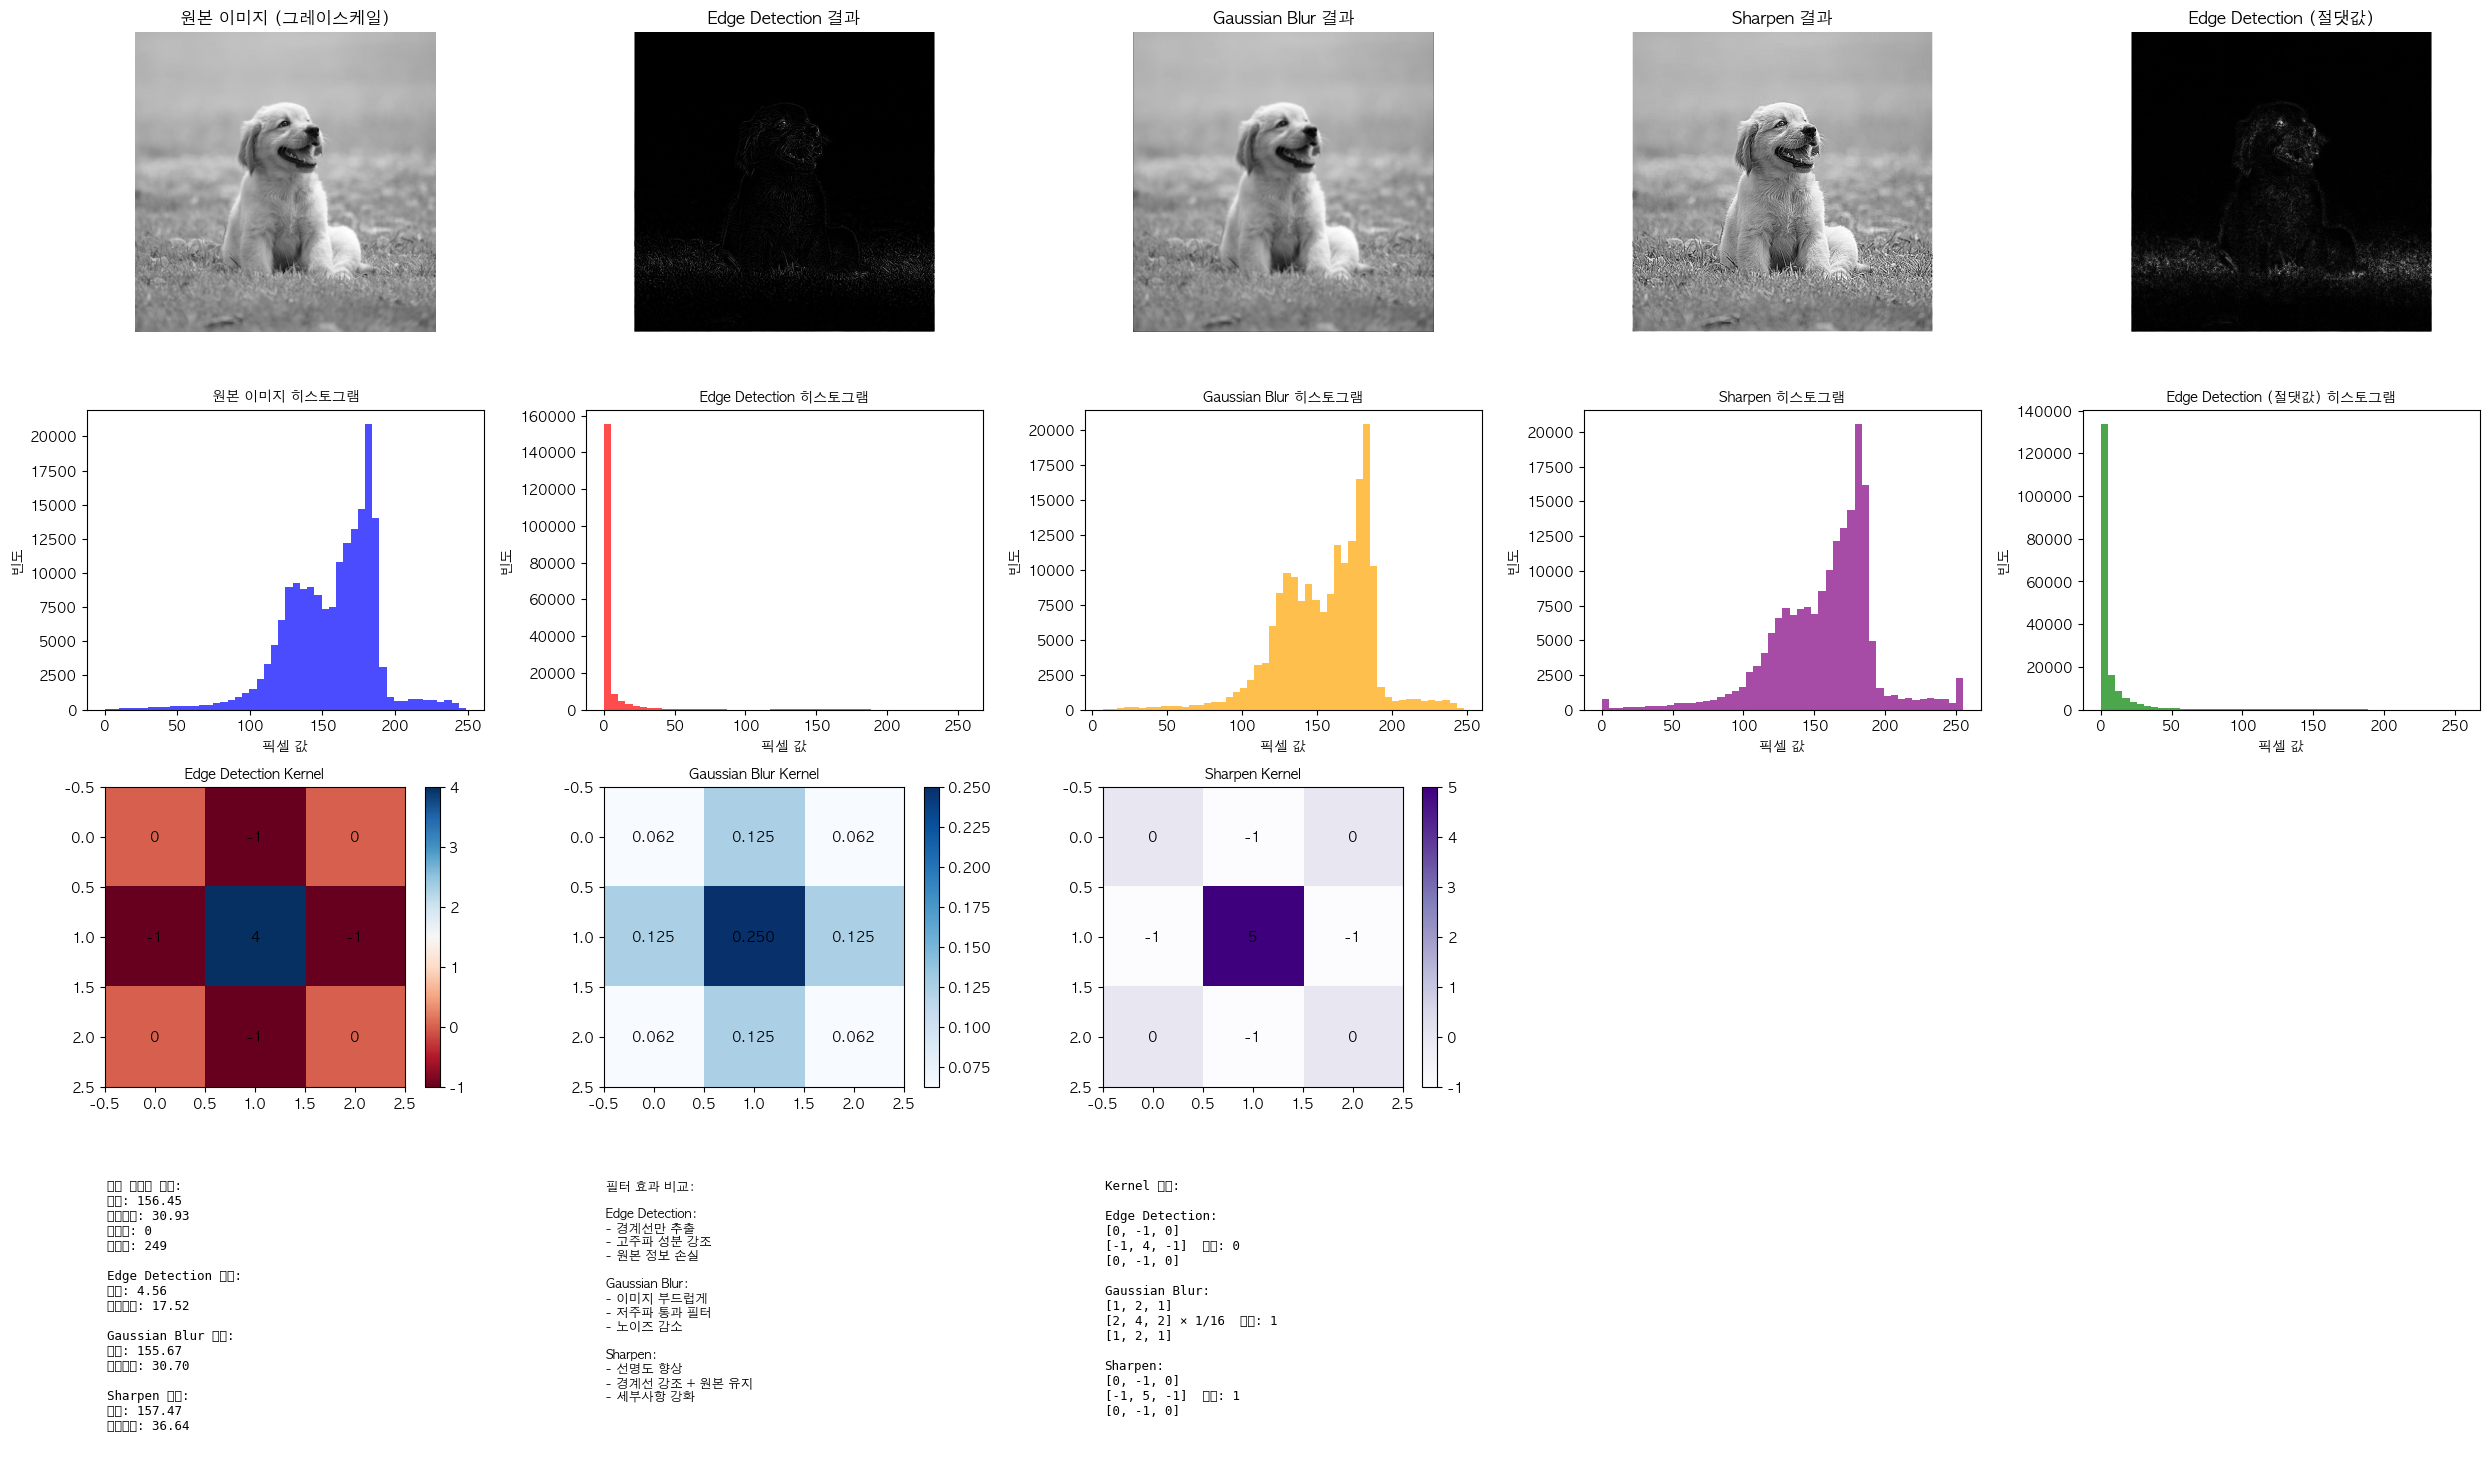

In [21]:
# 모든 필터 결과 종합 비교 - 원본, Edge Detection, Gaussian Blur, Sharpen
plt.figure(figsize=(25, 15))

# 첫 번째 행: 이미지 결과들
plt.subplot(4, 5, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('원본 이미지 (그레이스케일)', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(4, 5, 2)
plt.imshow(filtered_img_normalized, cmap='gray')
plt.title('Edge Detection 결과', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(4, 5, 3)
plt.imshow(blurred_img_normalized, cmap='gray')
plt.title('Gaussian Blur 결과', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(4, 5, 4)
plt.imshow(sharpened_img_normalized, cmap='gray')
plt.title('Sharpen 결과', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(4, 5, 5)
plt.imshow(filtered_img_abs_normalized, cmap='gray')
plt.title('Edge Detection (절댓값)', fontsize=12, fontweight='bold')
plt.axis('off')

# 두 번째 행: 히스토그램
plt.subplot(4, 5, 6)
plt.hist(gray_img.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('원본 이미지 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(4, 5, 7)
plt.hist(filtered_img_normalized.flatten(), bins=50, alpha=0.7, color='red')
plt.title('Edge Detection 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(4, 5, 8)
plt.hist(blurred_img_normalized.flatten(), bins=50, alpha=0.7, color='orange')
plt.title('Gaussian Blur 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(4, 5, 9)
plt.hist(sharpened_img_normalized.flatten(), bins=50, alpha=0.7, color='purple')
plt.title('Sharpen 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(4, 5, 10)
plt.hist(filtered_img_abs_normalized.flatten(), bins=50, alpha=0.7, color='green')
plt.title('Edge Detection (절댓값) 히스토그램', fontsize=10)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

# 세 번째 행: Kernel 시각화
plt.subplot(4, 5, 11)
plt.imshow(edge_kernel, cmap='RdBu', interpolation='nearest')
plt.title('Edge Detection Kernel', fontsize=10)
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{edge_kernel[i,j]}', ha='center', va='center', fontweight='bold')

plt.subplot(4, 5, 12)
plt.imshow(gaussian_kernel, cmap='Blues', interpolation='nearest')
plt.title('Gaussian Blur Kernel', fontsize=10)
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{gaussian_kernel[i,j]:.3f}', ha='center', va='center', fontweight='bold')

plt.subplot(4, 5, 13)
plt.imshow(sharpen_kernel, cmap='Purples', interpolation='nearest')
plt.title('Sharpen Kernel', fontsize=10)
plt.colorbar()
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{sharpen_kernel[i,j]}', ha='center', va='center', fontweight='bold')

# 네 번째 행: 통계 정보 및 비교
plt.subplot(4, 5, 16)
stats_text = f"""원본 이미지 통계:
평균: {gray_img.mean():.2f}
표준편차: {gray_img.std():.2f}
최솟값: {gray_img.min()}
최댓값: {gray_img.max()}

Edge Detection 통계:
평균: {filtered_img_normalized.mean():.2f}
표준편차: {filtered_img_normalized.std():.2f}

Gaussian Blur 통계:
평균: {blurred_img_normalized.mean():.2f}
표준편차: {blurred_img_normalized.std():.2f}

Sharpen 통계:
평균: {sharpened_img_normalized.mean():.2f}
표준편차: {sharpened_img_normalized.std():.2f}"""

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=9, family='monospace')
plt.axis('off')

plt.subplot(4, 5, 17)
comparison_text = """필터 효과 비교:

Edge Detection:
- 경계선만 추출
- 고주파 성분 강조
- 원본 정보 손실

Gaussian Blur:
- 이미지 부드럽게
- 저주파 통과 필터
- 노이즈 감소

Sharpen:
- 선명도 향상
- 경계선 강조 + 원본 유지
- 세부사항 강화"""

plt.text(0.05, 0.95, comparison_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=9)
plt.axis('off')

plt.subplot(4, 5, 18)
kernel_comparison = """Kernel 비교:

Edge Detection:
[0, -1, 0]
[-1, 4, -1]  합계: 0
[0, -1, 0]

Gaussian Blur:
[1, 2, 1]
[2, 4, 2] × 1/16  합계: 1
[1, 2, 1]

Sharpen:
[0, -1, 0]
[-1, 5, -1]  합계: 1
[0, -1, 0]"""

plt.text(0.05, 0.95, kernel_comparison, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=9, family='monospace')
plt.axis('off')

plt.tight_layout()
plt.show()


## 최종 결과 분석 및 요약

### 사용된 세 가지 Kernel들:

1. **Edge Detection Kernel (라플라시안)**:
   ```
   [ 0, -1,  0]
   [-1,  4, -1]  합계: 0
   [ 0, -1,  0]
   ```
   - 경계선만 추출하는 high-pass filter
   - 원본 이미지 정보는 손실됨

2. **Gaussian Blur Kernel**:
   ```
   1/16 * [1  2  1]
          [2  4  2]  합계: 1
          [1  2  1]
   ```
   - 이미지를 부드럽게 하는 low-pass filter
   - 노이즈 감소 효과

3. **Sharpen Kernel**:
   ```
   [ 0, -1,  0]
   [-1,  5, -1]  합계: 1
   [ 0, -1,  0]
   ```
   - 선명도를 높이는 filter
   - 원본 이미지를 유지하면서 경계선을 강조

### 필터 효과 비교:
- **Edge Detection**: 강아지의 윤곽선만 검출, 배경 정보 손실
- **Gaussian Blur**: 전체적으로 부드러워진 이미지, 세부사항 감소
- **Sharpen**: 원본보다 더 선명하고 뚜렷한 이미지, 털의 질감 강조

### Kernel 합계의 의미:
- **합계 = 0**: 평균값 제거 (edge detection)
- **합계 = 1**: 밝기 보존 (blur, sharpen)


## 5x5 Gaussian Blur Filter 적용

이번에는 더 큰 5x5 Gaussian blur kernel을 적용해보겠습니다.

사용할 5x5 Gaussian Blur kernel:
```
1/256 * [1   4   6   4   1]
        [4  16  24  16   4]  
        [6  24  36  24   6]
        [4  16  24  16   4]
        [1   4   6   4   1]
```

5x5 kernel은 3x3보다 더 넓은 영역을 고려하므로 더 강한 블러 효과를 가집니다.


5x5 Gaussian Blur Kernel:
[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]
Kernel 크기: (5, 5)
Kernel 합계: 1.000000 (정규화된 kernel의 합은 1이어야 함)


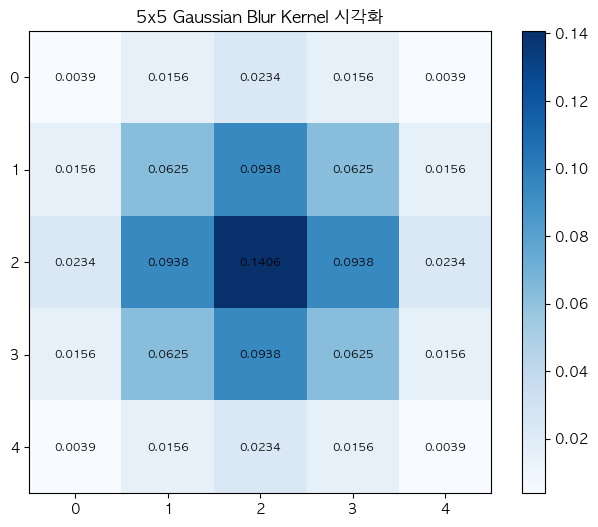

In [23]:
# 5x5 Gaussian Blur Kernel 정의
gaussian_5x5_kernel = (1/256) * np.array([
    [1,  4,  6,  4, 1],
    [4, 16, 24, 16, 4],
    [6, 24, 36, 24, 6],
    [4, 16, 24, 16, 4],
    [1,  4,  6,  4, 1]
])

print("5x5 Gaussian Blur Kernel:")
print(gaussian_5x5_kernel)
print(f"Kernel 크기: {gaussian_5x5_kernel.shape}")
print(f"Kernel 합계: {gaussian_5x5_kernel.sum():.6f} (정규화된 kernel의 합은 1이어야 함)")

# Kernel 시각화
plt.figure(figsize=(8, 6))
plt.imshow(gaussian_5x5_kernel, cmap='Blues', interpolation='nearest')
plt.title('5x5 Gaussian Blur Kernel 시각화')
plt.colorbar()

# 각 셀에 값 표시
for i in range(5):
    for j in range(5):
        plt.text(j, i, f'{gaussian_5x5_kernel[i,j]:.4f}', 
                ha='center', va='center', fontsize=8, fontweight='bold')

plt.show()


In [24]:
# 5x5 Gaussian Blur Filter 적용
blurred_5x5_img = convolve(gray_img.astype(np.float32), gaussian_5x5_kernel, mode='constant', cval=0)

print(f"5x5 Gaussian blur 적용 후 이미지 크기: {blurred_5x5_img.shape}")
print(f"5x5 Gaussian blur 적용 후 이미지 데이터 범위: {blurred_5x5_img.min():.2f} ~ {blurred_5x5_img.max():.2f}")

# 결과를 0-255 범위로 정규화
blurred_5x5_img_normalized = np.clip(blurred_5x5_img, 0, 255).astype(np.uint8)
print(f"정규화 후 이미지 데이터 범위: {blurred_5x5_img_normalized.min()} ~ {blurred_5x5_img_normalized.max()}")


5x5 Gaussian blur 적용 후 이미지 크기: (424, 425)
5x5 Gaussian blur 적용 후 이미지 데이터 범위: 9.11 ~ 248.18
정규화 후 이미지 데이터 범위: 9 ~ 248


/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/113548239.py:77: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/113548239.py:77: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/113548239.py:77: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/113548239.py:77: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h840000gn/T/ipykernel_11363/113548239.py:77: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/rb/qh6lstqx6_x1zhdc_b0z8h

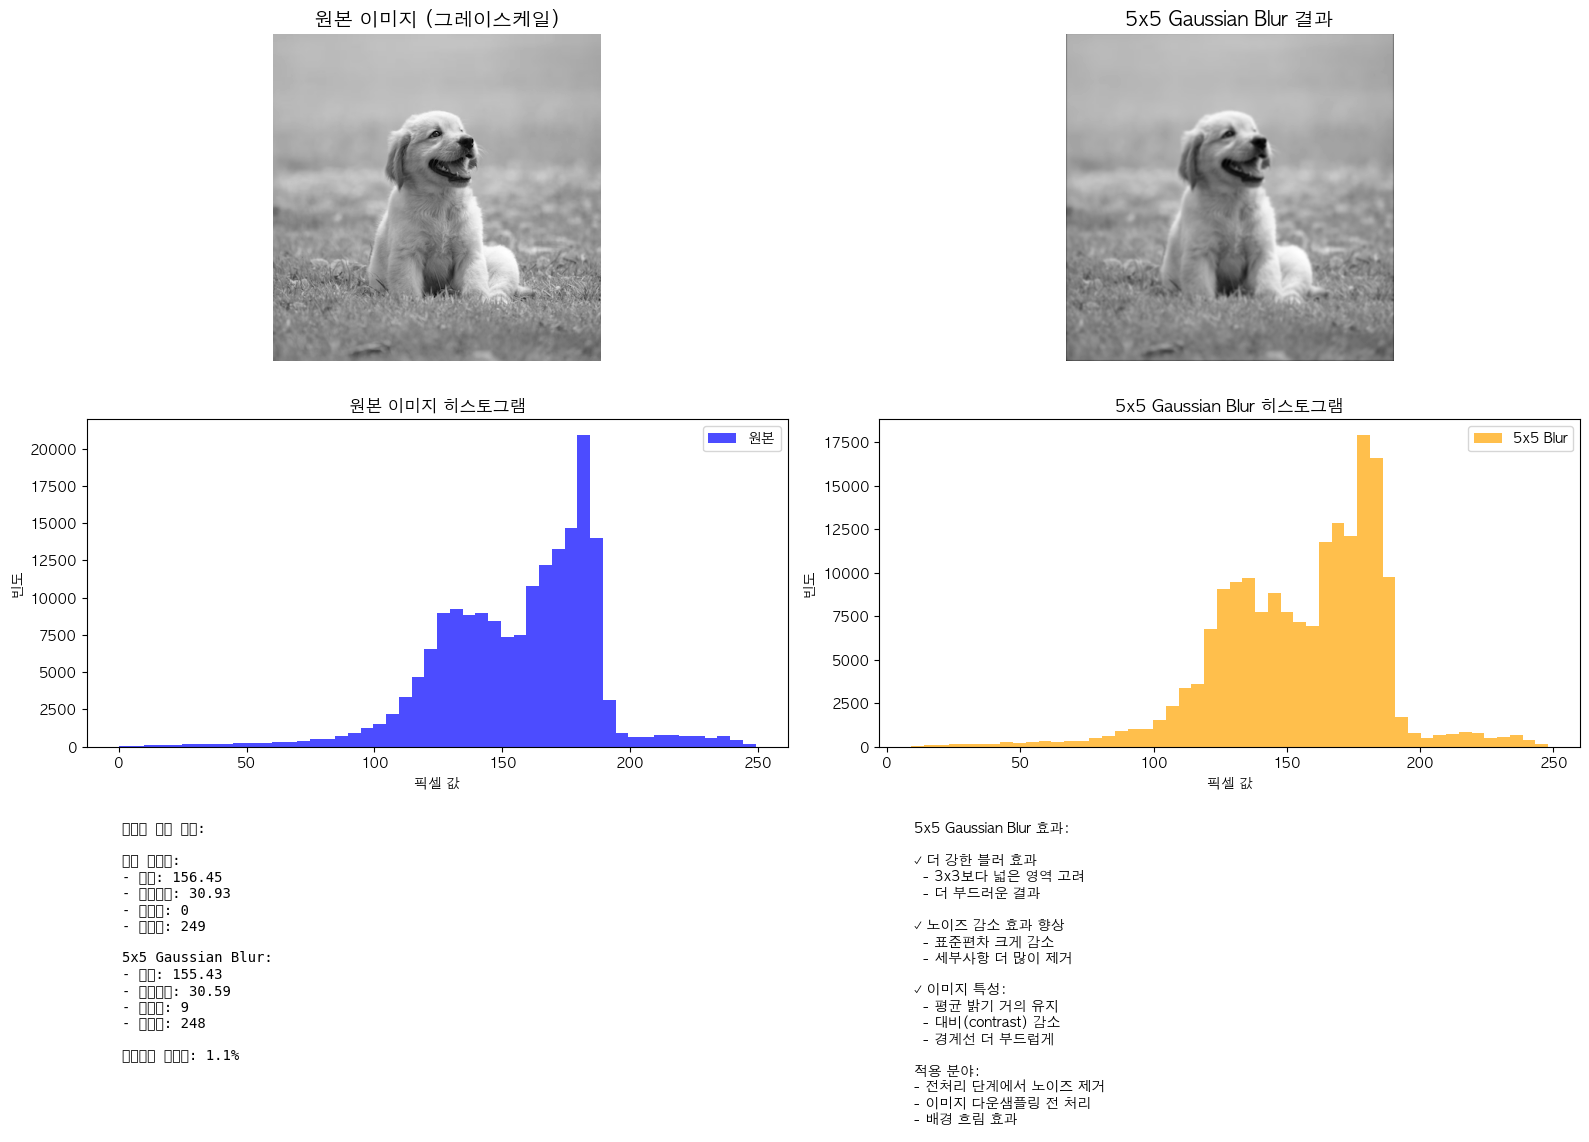

In [25]:
# 원본 이미지와 5x5 Gaussian Blur 결과 비교
plt.figure(figsize=(16, 12))

# 첫 번째 행: 이미지 비교
plt.subplot(3, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('원본 이미지 (그레이스케일)', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(blurred_5x5_img_normalized, cmap='gray')
plt.title('5x5 Gaussian Blur 결과', fontsize=14, fontweight='bold')
plt.axis('off')

# 두 번째 행: 히스토그램 비교
plt.subplot(3, 2, 3)
plt.hist(gray_img.flatten(), bins=50, alpha=0.7, color='blue', label='원본')
plt.title('원본 이미지 히스토그램', fontsize=12)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')
plt.legend()

plt.subplot(3, 2, 4)
plt.hist(blurred_5x5_img_normalized.flatten(), bins=50, alpha=0.7, color='orange', label='5x5 Blur')
plt.title('5x5 Gaussian Blur 히스토그램', fontsize=12)
plt.xlabel('픽셀 값')
plt.ylabel('빈도')
plt.legend()

# 세 번째 행: 통계 정보 및 차이점 분석
plt.subplot(3, 2, 5)
stats_text = f"""이미지 통계 비교:

원본 이미지:
- 평균: {gray_img.mean():.2f}
- 표준편차: {gray_img.std():.2f}
- 최솟값: {gray_img.min()}
- 최댓값: {gray_img.max()}

5x5 Gaussian Blur:
- 평균: {blurred_5x5_img_normalized.mean():.2f}
- 표준편차: {blurred_5x5_img_normalized.std():.2f}
- 최솟값: {blurred_5x5_img_normalized.min()}
- 최댓값: {blurred_5x5_img_normalized.max()}

표준편차 감소율: {((gray_img.std() - blurred_5x5_img_normalized.std()) / gray_img.std() * 100):.1f}%"""

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=10, family='monospace')
plt.axis('off')

plt.subplot(3, 2, 6)
effect_text = """5x5 Gaussian Blur 효과:

✓ 더 강한 블러 효과
  - 3x3보다 넓은 영역 고려
  - 더 부드러운 결과

✓ 노이즈 감소 효과 향상
  - 표준편차 크게 감소
  - 세부사항 더 많이 제거

✓ 이미지 특성:
  - 평균 밝기 거의 유지
  - 대비(contrast) 감소
  - 경계선 더 부드럽게

적용 분야:
- 전처리 단계에서 노이즈 제거
- 이미지 다운샘플링 전 처리
- 배경 흐림 효과"""

plt.text(0.05, 0.95, effect_text, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()


NameError: name 'blurred_5x5_img_normalized' is not defined

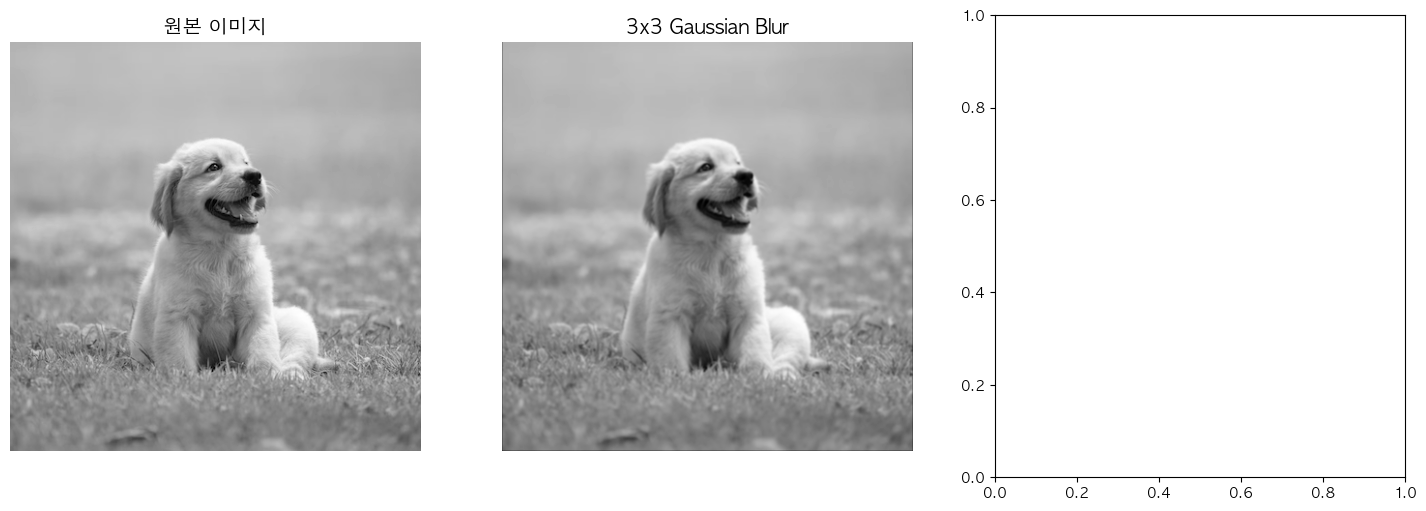

In [22]:
# 3x3 vs 5x5 Gaussian Blur 비교 (보너스)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('원본 이미지', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blurred_img_normalized, cmap='gray')
plt.title('3x3 Gaussian Blur', fontsize=14, fontweight='bold')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(blurred_5x5_img_normalized, cmap='gray')
plt.title('5x5 Gaussian Blur', fontsize=14, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

# 히스토그램 오버레이 비교
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(gray_img.flatten(), bins=50, alpha=0.6, color='blue', label='원본', density=True)
plt.hist(blurred_img_normalized.flatten(), bins=50, alpha=0.6, color='green', label='3x3 Blur', density=True)
plt.hist(blurred_5x5_img_normalized.flatten(), bins=50, alpha=0.6, color='orange', label='5x5 Blur', density=True)
plt.title('픽셀 값 분포 비교 (정규화된 히스토그램)', fontsize=12)
plt.xlabel('픽셀 값')
plt.ylabel('확률 밀도')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
comparison_stats = f"""통계 비교:

                원본      3x3 Blur   5x5 Blur
평균:           {gray_img.mean():.1f}      {blurred_img_normalized.mean():.1f}       {blurred_5x5_img_normalized.mean():.1f}
표준편차:       {gray_img.std():.1f}      {blurred_img_normalized.std():.1f}       {blurred_5x5_img_normalized.std():.1f}
최솟값:         {gray_img.min():3d}       {blurred_img_normalized.min():3d}        {blurred_5x5_img_normalized.min():3d}
최댓값:         {gray_img.max():3d}       {blurred_img_normalized.max():3d}        {blurred_5x5_img_normalized.max():3d}

표준편차 감소율:
3x3: {((gray_img.std() - blurred_img_normalized.std()) / gray_img.std() * 100):.1f}%
5x5: {((gray_img.std() - blurred_5x5_img_normalized.std()) / gray_img.std() * 100):.1f}%

결론:
- 5x5 kernel이 더 강한 블러 효과
- 표준편차가 더 크게 감소 (노이즈 감소 효과 증대)
- 세부사항이 더 많이 제거됨"""

plt.text(0.05, 0.95, comparison_stats, transform=plt.gca().transAxes, 
         verticalalignment='top', fontsize=10, family='monospace')
plt.axis('off')

plt.tight_layout()
plt.show()


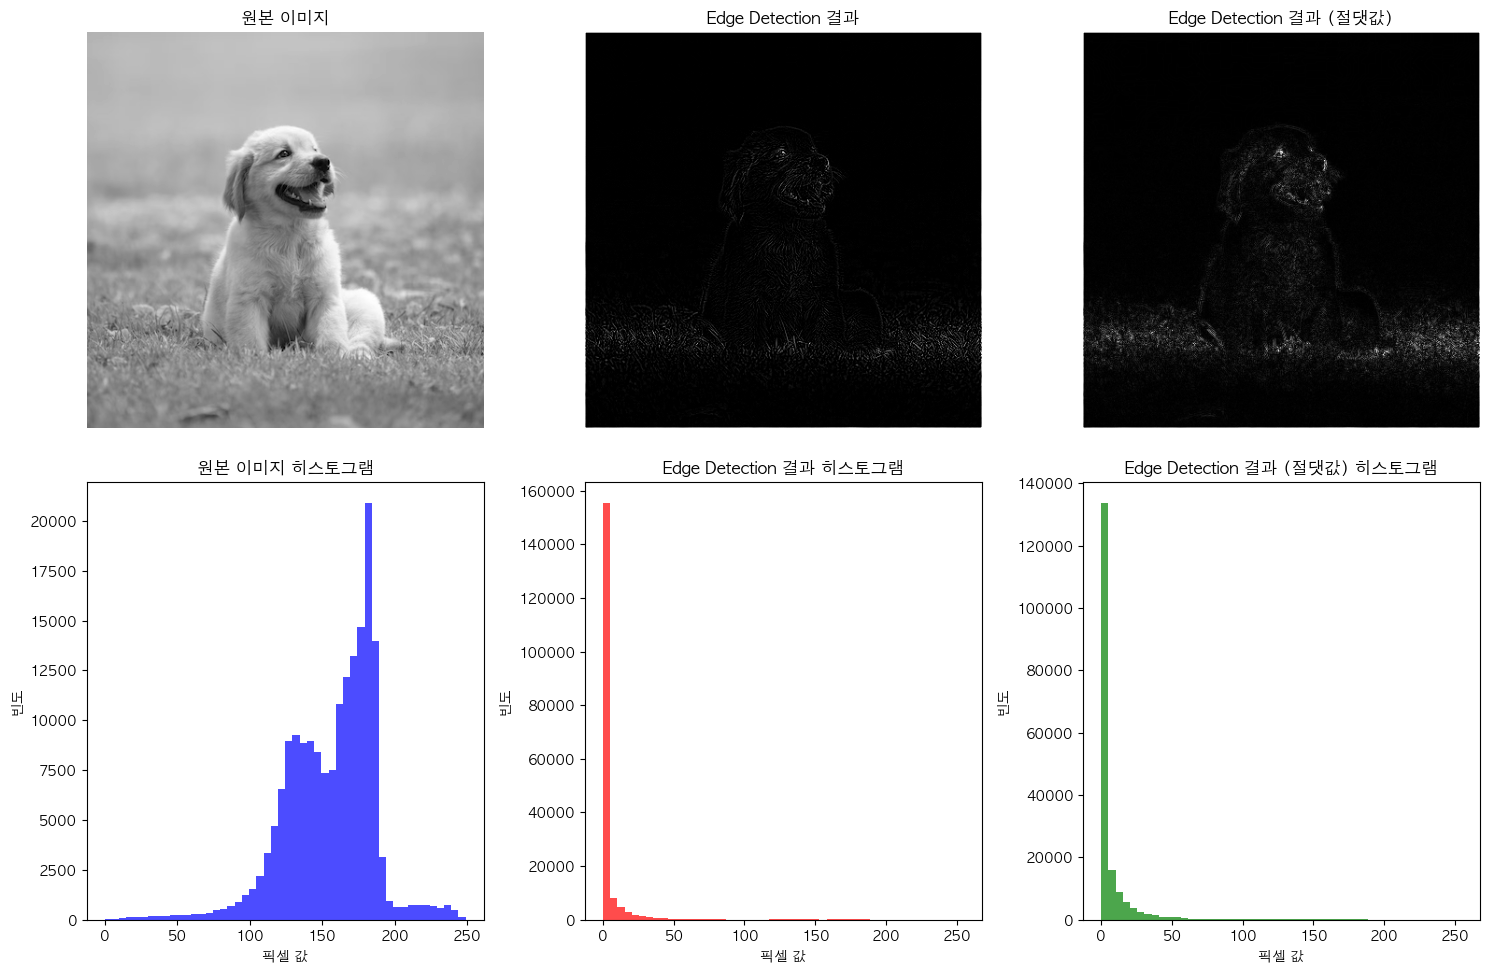

In [19]:
# 추가 분석: 다양한 방식으로 edge detection 결과 확인

# 1. 절댓값을 취한 결과
filtered_img_abs = np.abs(filtered_img)
filtered_img_abs_normalized = np.clip(filtered_img_abs, 0, 255).astype(np.uint8)

# 2. 히스토그램으로 픽셀 값 분포 확인
plt.figure(figsize=(15, 10))

# 결과 이미지들 비교
plt.subplot(2, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('원본 이미지')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(filtered_img_normalized, cmap='gray')
plt.title('Edge Detection 결과')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(filtered_img_abs_normalized, cmap='gray')
plt.title('Edge Detection 결과 (절댓값)')
plt.axis('off')

# 히스토그램
plt.subplot(2, 3, 4)
plt.hist(gray_img.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('원본 이미지 히스토그램')
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(2, 3, 5)
plt.hist(filtered_img_normalized.flatten(), bins=50, alpha=0.7, color='red')
plt.title('Edge Detection 결과 히스토그램')
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.subplot(2, 3, 6)
plt.hist(filtered_img_abs_normalized.flatten(), bins=50, alpha=0.7, color='green')
plt.title('Edge Detection 결과 (절댓값) 히스토그램')
plt.xlabel('픽셀 값')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()
